# Exploração de Dados - Data Mining

Rui Frazão - 80963
Fábio Xavier - 73210

In [1]:
import warnings
warnings.filterwarnings("ignore")

from os import listdir
import time
from IPython.display import Image, HTML
from subprocess import call

import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.tools.plotting import parallel_coordinates

from sklearn.feature_selection import f_classif, chi2, RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve, confusion_matrix

from statistics import mean

/usr/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def model_evaluation_report(real, predicted, return_=False):
    classes = predicted.unique()
    
    print("Confusion Matrix:\n", confusion_matrix(real, predicted))
    
    accuracy = accuracy_score(real, predicted)
    error_rate = 1 - accuracy
    precision, recall, fscore, support = precision_recall_fscore_support(real, predicted)
    precision, recall, fscore = mean(precision), mean(recall), mean(fscore)

    print('\nAccuracy: %s' % accuracy)
    print('Mean Precision: %s' % precision)
    print('Mean Recall: %s' % recall)
    print('Mean FScore: %s' % fscore)
    print('Ocurrences of each class: %s' % support)
    
    metrics = dict()
    metrics['accuracy'] =  accuracy
    metrics['error_rate'] = error_rate
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f_measure'] = fscore
    metrics['support'] = support
    
    if return_:
        return metrics

In [3]:
def nested_cross_validation(classifier, X, y, p_grid, num_trials = 10, verbose=False):
    # Arrays to store scores
    non_nested_scores = np.zeros(num_trials)
    nested_scores = np.zeros(num_trials)

    # Loop for each trial
    for i in range(num_trials):
        start_time = time.time()

        # Choose cross-validation techniques for the inner and outer loops,
        # independently of the dataset.
        # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
        inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=classifier, param_grid=p_grid, cv=inner_cv)
        clf.fit(X, y)
        non_nested_scores[i] = clf.best_score_

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
        nested_scores[i] = nested_score.mean()
        
        if verbose:
            print("Trial %s: Time: %s secs." %  (i, time.time()-start_time))

    score_difference = non_nested_scores - nested_scores
    
    print("Non-Nested Score: %s \nNested Score %s " % (mean(non_nested_scores), mean(nested_scores)))

    print("Average difference of {0:6f} with std. dev. of {1:6f}."
          .format(score_difference.mean(), score_difference.std()))
    
    plt.figure()
    plt.subplot(211)
    non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
    nested_line, = plt.plot(nested_scores, color='b')
    plt.ylabel("score", fontsize="14")
    plt.legend([non_nested_scores_line, nested_line],
               ["Non-Nested CV", "Nested CV"],
               bbox_to_anchor=(0, .4, .5, 0))
    plt.title("Non-Nested and Nested Cross Validation Comparison",
              x=.5, y=1.1, fontsize="15")

    # Plot bar chart of the difference.
    plt.subplot(212)
    difference_plot = plt.bar(range(num_trials), score_difference)
    plt.xlabel("Trial #")
    plt.legend([difference_plot],
               ["Non-Nested CV - Nested CV Score"],
               bbox_to_anchor=(0, 1, .8, 0))
    plt.ylabel("score difference", fontsize="14")

    plt.show()

# Introdução
---

Este trabalho está inserido na unidade curriular de Exploração de Dados / Data Mining do Mestrado em Engenharia Informática.

Este trabalho tem como objetivo a análise e exploração de dois datasets distintos, em que sejam aplicados conhecimentos obtidos na UC em questão.

Devem ser aplicadas técnicas de pré processamento, como codificação de atributos categóricos, normalização e mecanismos de redução de dimensionalidade e ranking de features, criados modelos preditivos de classificação utilizando algoritmos próprios para a tarefa de classificação e numa fase final, a avaliação dos modelos preditivos, recorrendo a técnicas como holdout ou cross-validation.

Para executar este notebook é necessário ter instalados os seguintes pacotes:
* Python3;
* Sciki-Learn;
* Pandas;
* Numpy;
* Matplotlib;
* Graphviz;
* IPython;
* subprocess module (linux).

Foi dada importância à parte da visualização e compreensão dos dados, visto que esta é das partes mais consumidoras de tempo num projeto de _data mining_.

# Car Evaluation Dataset

## Sobre o Dataset:

Classificação de carros com base nos seguintes atributos:

* Relacionados com Preço:
    * Preço de compra
    * Preço de manutenção
* Caraterísticas Técnicas:
    * Número de portas
    * Limite de pessoas
    * Tamanho da mala traseira
    * Segurança estimada

Com base nesses atributos deve ser analisado o estado do carro, classificando-o em:
* Inaceitável (unacc)
* Aceitável (acc)
* Bom (good)
* Muito bom (vgood)

## Compreensão dos Dados

In [4]:
cars_attributes=['buying', 'maint', 'doors', 'persons', 
                 'lug_boot', 'safety', 'class']
cars_df = pd.read_csv('./dataset/car.data', header=None, 
                      names=cars_attributes)
cars_df = cars_df.infer_objects()
cars_df.head()

buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

In [5]:
cars_df.describe()

buying maint doors persons lug_boot safety  class
count    1728  1728  1728    1728     1728   1728   1728
unique      4     4     4       3        3      3      4
top       low   low     4       4      big    low  unacc
freq      432   432   432     576      576    576   1210

### Levantamento das features e dos seus valores

In [6]:
[(feature, cars_df[feature].unique()) for feature in cars_df.columns]

[('buying', array(['vhigh', 'high', 'med', 'low'], dtype=object)),
 ('maint', array(['vhigh', 'high', 'med', 'low'], dtype=object)),
 ('doors', array(['2', '3', '4', '5more'], dtype=object)),
 ('persons', array(['2', '4', 'more'], dtype=object)),
 ('lug_boot', array(['small', 'med', 'big'], dtype=object)),
 ('safety', array(['low', 'med', 'high'], dtype=object)),
 ('class', array(['unacc', 'acc', 'vgood', 'good'], dtype=object))]

## Encoding de Features categóricas

Encoding das categorical features:
* OneHotEncoding / Bitmap Indexing- causa aumento do número de dimensões;
* LabelEncoding - Atribuição de índices a cada variante das features

https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor

### Levantamento de valores nulos ou em falta

In [7]:
cars_df.isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Não existem valores nulos, logo não é necessário efetuar qualquer operação para atuar sobre valores nulos ou inválidos.

### Encoding das features categóricas

In [8]:
#custom label encoding
def labelEncoding(df, features, verbose=False):
    """
        Returns encoded dataframe ([0]) and encoding dict ([1])
    """
    encoded_df = df
    encoding_matrix = dict()
    for feature in features:
        encoded_features = dict()
        unique_list = list(df[feature].unique())
        for ft_var in unique_list:
            encoded_features[ft_var] = unique_list.index(ft_var)
        encoding_matrix[feature]=encoded_features
        if verbose:
            print(feature, encoded_features)

        encoded_df[feature].replace(encoded_features, inplace=True)
    return encoded_df, encoding_matrix

In [9]:
X = pd.get_dummies(cars_df[cars_df.columns[:-1]])
y = labelEncoding(cars_df[['class']], ['class'], True)[0]

class {'unacc': 0, 'acc': 1, 'vgood': 2, 'good': 3}


In [10]:
y = y['class']

In [11]:
def plot_encode(value):
    if (value == 'small' or value == 'low'):
        return 0
    elif (value == 'med'):
        return 1
    elif (value == 'high' or value == 'big'):
        return 2
    elif (value == 'vgood' or value == 'vhigh'):
        return 3
    elif (value == 'more' or value == '5more'):
        return 5
    else:
        return value

df_copy = cars_df.copy()
df_copy['doors'] = df_copy['doors'].apply(plot_encode)
df_copy['persons'] = df_copy['persons'].apply(plot_encode)
df_copy['buying'] = cars_df['buying'].apply(plot_encode)
df_copy['maint'] = cars_df['maint'].apply(plot_encode)
df_copy['lug_boot'] = labelEncoding(cars_df[['lug_boot']], 
                                    ['lug_boot'])[0]
df_copy['safety'] = labelEncoding(cars_df[['safety']], ['safety'])[0]

In [12]:
df_unacc = df_copy[df_copy['class'] == 'unacc']
df_acc = df_copy[df_copy['class'] == 'acc']
df_good = df_copy[df_copy['class'] == 'good']
df_vgood = df_copy[df_copy['class'] == 'vgood']

#### Análise dos valores das features e relação com a classe que representam

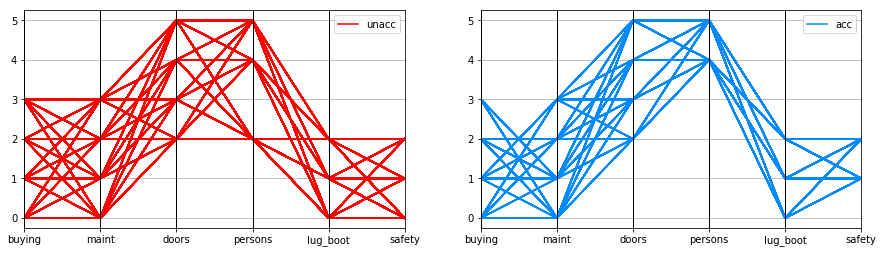

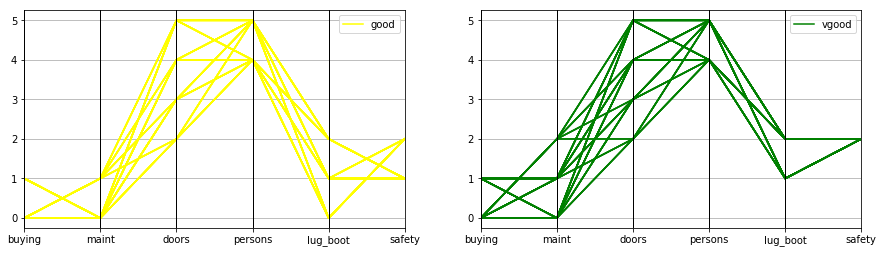

In [13]:
%matplotlib inline

#unacc
plt.subplot(1,2,1)
parallel_coordinates(df_unacc, 'class', cols=df_unacc.columns[:-1],
                     color=('#FF0000'))
plt.gcf().set_size_inches((15,4))

#acc
plt.subplot(1,2,2)
parallel_coordinates(df_acc, 'class', cols=df_acc.columns[:-1],
                     color=('#008AFC'))
plt.gcf().set_size_inches((15,4))
plt.show()

#good
plt.subplot(1,2,1)
parallel_coordinates(df_good, 'class', cols=df_good.columns[:-1],
                     color=('#FFFF00'))
plt.gcf().set_size_inches((15,4))

#vgood
plt.subplot(1,2,2)
parallel_coordinates(df_vgood, 'class', cols=df_vgood.columns[:-1],
                     color=('#008000'))

plt.gcf().set_size_inches((15,4))
plt.show()

Através do gráfico de coordenadas paralelas, é possível analisar as relações entre os atributos e as etiquetas relativas ao estado do veículo.

Na primeira figura (linha vermelha), é possível verificar que os veículos classificados como em estado inaceitável possuem preços de compra elevados e de manutenção, alguns têm poucas portas e lugares para passageiros, pouco espaço de mala e segurança baixa.

Na segunda figura (linha azul) verifica-se que existem diferenças relativamente à primeira, principalmente no preço de compra, número de pessoas que o carro transporta e não existem valores de segurança tão baixos. Mesmo assim, estes carros são apenas classificados como sendo "aceitáveis".

Na terceira figura (linha amarela) notam-se melhorias nos atributos relativamente às anteriores. Os preços de compra e manutenção são mais baixos, mas o tamanho da mala continua a ser reduzido. Estes são classificados como "bons".

Na última figura (linha verde) entende-se a classificação como "muito bom", pois se nota que os preços de compra e manutenção são reduzidos, o número de portas é elevado e consequentement o número de pessoas que pode transportar também, o tamanho de mala maior é mais frequente e a segurança tende a ser melhor.

#### Análise da distribuição das labels

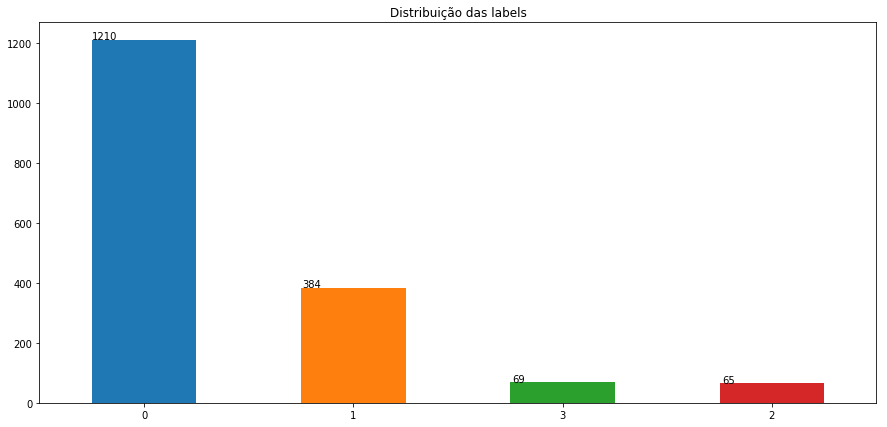

In [14]:
ax = pd.value_counts(y).plot(kind="bar", 
                             title="Distribuição das labels", 
                             rot=0, figsize=(15,7))
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() * 1.005, p.get_height() * 1.005))

Como é de reparar pela figura anterior, a distribuição dos dados não é balanceada. Existem muito mais instâncias classificadas com uma classe do que com as restantes.

In [15]:
print("Numero de registos: ",X.shape[0])
print("Numero de features: ",X.shape[1])

Numero de registos:  1728
Numero de features:  21


## Feature Ranking

Teste F estatístico. Este teste testa a hipótese de as variâncias das caraterísticas serem bastante diferentes, permitindo classificá-las de acordo com a influência que estas têm no resultado final.

<!--$$H_0: feature_{var} $$-->

Relalizando um teste F com um grau de confiança a 95%, caso o valor-p seja inferior ao alfa, rejeita-se a hipótese nula, sendo assim a variância dessa caraterística elevada.

In [16]:
df_feature_ranking = pd.DataFrame()

alpha = 0.05

X_feature_rank = f_classif(X, y)

df_feature_ranking['feature'] = X.columns
df_feature_ranking['f_value'] = X_feature_rank[0]
df_feature_ranking['p_value'] = X_feature_rank[1]
df_feature_ranking['f_test'] = df_feature_ranking['p_value'].apply(lambda p: p < alpha)

#### Features mais relevantes | elevada variância

In [17]:
(df_feature_ranking[df_feature_ranking['f_test'] == True])

feature     f_value       p_value  f_test
0      buying_high   16.666895  1.124079e-10    True
1       buying_low   41.263195  9.495716e-26    True
2       buying_med    6.938783  1.216456e-04    True
3     buying_vhigh   23.266687  9.192350e-15    True
4       maint_high    8.632896  1.094960e-05    True
5        maint_low   26.858877  5.625836e-17    True
6        maint_med    6.938783  1.216456e-04    True
7      maint_vhigh   23.266687  9.192350e-15    True
8          doors_2    3.061020  2.722089e-02    True
12       persons_2  156.507523  0.000000e+00    True
13       persons_4   36.904675  4.109193e-23    True
14    persons_more   28.941366  2.961221e-18    True
15    lug_boot_big   10.489945  7.733261e-07    True
17  lug_boot_small   16.088266  2.571159e-10    True
18     safety_high  101.890305  0.000000e+00    True
19      safety_low  156.507523  0.000000e+00    True
20      safety_med   31.156036  1.304077e-19    True

#### Features menos relevantes | baixa variância

In [18]:
less_relevant_features = (
    df_feature_ranking[df_feature_ranking['f_test'] == False]
)['feature']
(df_feature_ranking[df_feature_ranking['f_test'] == False])

feature   f_value   p_value  f_test
9        doors_3  0.107843  0.955532   False
10       doors_4  0.726990  0.535854   False
11   doors_5more  0.726990  0.535854   False
16  lug_boot_med  0.628014  0.596922   False

## RFE - Recursive Feature Elimination

Para complementar o resultado obtido anteriormente, foi utilizando um método de seleção de features através da eliminação recursiva das features com o objetivo de analisar a influência de cada no resultado final da classificação.

Neste método RFE é treinado um classificador e com base nas features presentes no dataset e no resultado que estas devem obter, vão sendo excluídas as features e pesada a influência destas para o resultado final obtido.

No fim, obtém-se uma lista de features ordenada de acordo com a sua importância. Quanto mais próximo de 1, melhor o rank da feature.

Foi adoptado o método RFECV, pois este utiliza cross-validation para a comparação do desempenho do classificador e desta forma deve obter um resultado mais correto para a análise da influência da feature.

In [19]:
df_feature_ranking_rfe = pd.DataFrame()

selector = RFECV(LinearSVC(), step=1, cv=5)
selector = selector.fit(X, y)

df_feature_ranking_rfe['feature'] = X.columns
df_feature_ranking_rfe['rank'] = selector.ranking_

df_feature_ranking_rfe.sort_values(by='rank')

feature  rank
0      buying_high     1
17  lug_boot_small     1
3     buying_vhigh     1
7      maint_vhigh     1
12       persons_2     1
19      safety_low     1
18     safety_high     2
4       maint_high     3
13       persons_4     4
14    persons_more     5
20      safety_med     6
8          doors_2     7
1       buying_low     8
15    lug_boot_big     9
5        maint_low    10
6        maint_med    11
2       buying_med    12
9          doors_3    13
16    lug_boot_med    14
11     doors_5more    15
10         doors_4    16

In [20]:
X_relevant = X.drop(less_relevant_features, axis=1)

In [21]:
X_relevant.shape
X = X_relevant

## Normalização (Feature Scaling)

### Min-Max Normalization
Centrar os dados / Redução da amplitude dos dados

$X = \frac{X - min(X)}{max(X)-min(X)}$

In [22]:
minMaxNormalization = MinMaxScaler()
X = minMaxNormalization.fit_transform(X)

### Normalização Z-Score

Normalização Z-Score (Standard). Distribuição normal dos dados, em que $\mu=0$ e $\sigma=1$

$X = \frac{X-\mu}{\sigma}$

In [23]:
ZScore = StandardScaler()
X = ZScore.fit_transform(X)

## Predictive Model

## SVC - Support Vector Classifier

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
svc = SVC()
svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Análise do desempenho - Holdout

In [26]:
print("Holdout Score:")
model_evaluation_report(svc.predict(X_test), y_test)

Holdout Score:
Confusion Matrix:
 [[235   0   0   0]
 [  0  74   0   0]
 [  0   2  17   2]
 [  0   7   0   9]]

Accuracy: 0.9682080924855492
Mean Precision: 0.9274370208105148
Mean Recall: 0.8430059523809523
Mean FScore: 0.8760196670018996
Ocurrences of each class: [235  74  21  16]


Utilizando apenas um Support Vector Classifier sem qualquer tuning de parâmetros obtem-se um classificador com uma precisão elevada de classificação. Tal pode ocorrer devido a overfitting.

Dado que o resultado obtido foi resultado da utilização do método de classificação "holdout", deve ser utilizado também Cross-Validation para realizar uma análise mais robusta ao desempenho do classificador.

### Análise do desempenho - Stratified K-Fold Cross-Validation

Nesta fase utilizou-se StratifiedKFold Cross-Validation dado que este método de Stratified Sampling cria folds em que as ditribuições de cada classe são iguais. Isto é relevante para este tipo de dataset porque não são balanceados.

In [27]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(svc, X, y, cv=skf)
scores

array([0.73988439, 0.82080925, 0.85260116, 0.86127168, 0.7877907 ])

In [28]:
print('Cross-Validation Scores Mean: ', scores.mean())

Cross-Validation Scores Mean:  0.8124714343325715


Com a utilização de Cross-Validation consegue-se obter um valor mais realista do desempenho do modelo.

Numa fase posterior, é possível melhorar esse classificador testando diferentes valores dos seus parâmetros. Para isso foi utilizado GridSearchCV que testa as diferentes combinações dos parâmetros desejados e treina os diferentes classificadores utilizando cross-validation. No final deste processo é devolvido o classificador que obteve melhor resultado na classificação.

## Parameter Tuning

### GridSearch

In [29]:
%%time
params = {
    'kernel':['linear', 'rbf', 'sigmoid', 'poly'],
    'C':[x for x in range(1,10, 1)]
}

skf = StratifiedKFold(n_splits=5)

svc = SVC()
grid_search_svc = GridSearchCV(svc, params, cv=skf)
grid_search_svc.fit(X, y)

CPU times: user 9.79 s, sys: 2.48 ms, total: 9.79 s
Wall time: 9.81 s


In [30]:
grid_search_svc.best_params_

{'C': 6, 'kernel': 'rbf'}

#### Resultados Cross-Validation após GridSearch

In [31]:
gs_cv = pd.DataFrame(grid_search_svc.cv_results_)

In [32]:
gs_score = gs_cv[gs_cv['params']==grid_search_svc.best_params_]['mean_test_score']
gs_score = float(gs_score)

In [33]:
print("After parameter tuning precision: ", gs_score)

After parameter tuning precision:  0.8396990740740741


In [34]:
best_svc = grid_search_svc.best_estimator_

### Análise do desempenho - Nested Cross-Validation

Non-Nested Score: 0.9856770833333334 
Nested Score 0.9829571759259259 
Average difference of 0.002720 with std. dev. of 0.001822.


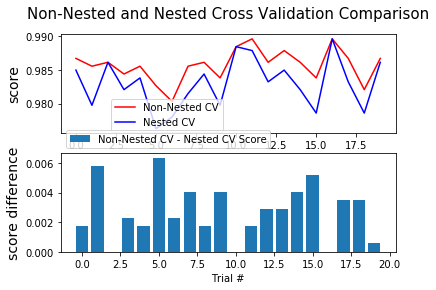

CPU times: user 8min 44s, sys: 28.7 ms, total: 8min 44s
Wall time: 8min 45s


In [35]:
%%time
ncv_svc = SVC()
ncv_svc_scores = nested_cross_validation(ncv_svc, X, y, params, num_trials=20)

A utilização deste método de avaliação "Nested Cross-Validation" implica o afinamento de parâmetros a cada fold.
Esta versão pode ser mais consumidora de tempo, e segundo o artigo "_Nested cross-validation when selecting classifiers is overzealous for most practical applications_", utilizando este método nem sempre oferece vantagem face a uma implementação menos consumidora de tempo e menos iterativa do cross-validation, pois o método "clássico" geralmente seleciona o algoritmo que, em termos práticos, é mais semelhante ao selectionado pelo método de nested cross-validation.

## Random Forest Classifier

Utilização de Random Forest, utilizando bootstrap e análise do desempenho através do out-of-bag score

In [36]:
#setup
X = labelEncoding(cars_df[cars_df.columns[:-1]], cars_df.columns[:-1], False)[0]
y = labelEncoding(cars_df[cars_df.columns[-1:]], cars_df.columns[-1:], False)[0]

Através do atributo *feature_importances_* é possível analisar quais as features que mais influência têm na classificação.

In [37]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt', oob_score=True, bootstrap=True)
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [38]:
for ft in range(len(X.columns)):
    print("Feature: {:<10} Importance: {}".format(X.columns[ft], rfc.feature_importances_[ft]))

Feature: buying     Importance: 0.11784430080884184
Feature: maint      Importance: 0.10677154837203222
Feature: doors      Importance: 0.009855725001419614
Feature: persons    Importance: 0.34318224977202755
Feature: lug_boot   Importance: 0.03839912465091411
Feature: safety     Importance: 0.3839470513947646


#### Representação de uma instância da Random Forest

In [39]:
files_in_dir = listdir('./')

if 'tree_example.png' not in files_in_dir:
    export_graphviz(rfc.estimators_[0], out_file='tree_example.dot', feature_names = cars_df.columns[:-1],
                    class_names = cars_df['class'].unique(), rounded = True, proportion = False,
                    precision = 2, filled = True)

    ### dot -Tpng mlp_scheme.dot -o mlp_scheme.png -Gdpi=600
    call(['dot', '-Tpng', 'tree_example.dot', '-o', 'tree_example.png', '-Gdpi=600'])
Image(filename = 'tree_example.png')

### Análise do desempenho - Out-of-Bag Score

In [40]:
print("Decision Tree Score: %s" % round(rfc.oob_score_, 3))

Decision Tree Score: 0.881


### Análise desempenho - Stratified K-Fold Cross-Validation

In [41]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(rfc, X, y, cv=skf)
scores

array([0.71387283, 0.78323699, 0.72543353, 0.86127168, 0.86627907])

In [42]:
print('Cross-Validation Scores Mean: ', scores.mean())

Cross-Validation Scores Mean:  0.7900188197338351


## Parameter Tuning

### GridSearch

In [43]:
%%time
params = {
    'n_estimators': [x for x in range(50,200, 50)],
    'max_depth':[x for x in range(1,11, 4)],
    'max_features': ['sqrt', 'log2']
}

gs_rfc = RandomForestClassifier(n_jobs=5)
skf = StratifiedKFold(n_splits=5)

grid_search_rfc = GridSearchCV(gs_rfc, params, cv=skf)
grid_search_rfc.fit(X, y)

CPU times: user 23.5 s, sys: 4.96 s, total: 28.5 s
Wall time: 36.7 s


In [44]:
grid_search_rfc.best_params_

{'max_depth': 9, 'max_features': 'log2', 'n_estimators': 100}

### Resultados Cross-Validation após GridSearch

In [45]:
gs_cv = pd.DataFrame(grid_search_rfc.cv_results_)

In [46]:
gs_score = gs_cv[gs_cv['params']==grid_search_rfc.best_params_]['mean_test_score']
gs_score = float(gs_score)

In [47]:
print("After parameter tuning precision: ", gs_score)

After parameter tuning precision:  0.8107638888888888


In [48]:
best_rfc = grid_search_rfc.best_estimator_

### Análise do desempenho - Nested Cross-Validation

Non-Nested Score: 0.9734375000000001 
Nested Score 0.9703125 
Average difference of 0.003125 with std. dev. of 0.002629.


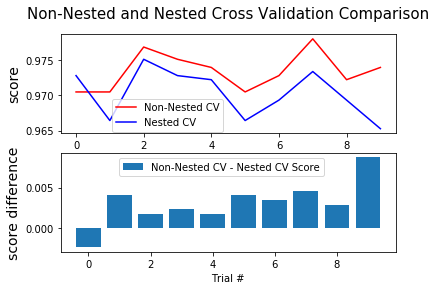

CPU times: user 15min 14s, sys: 3min 38s, total: 18min 53s
Wall time: 24min 33s


In [49]:
%%time
ncv_rfc = RandomForestClassifier(n_jobs=5)
ncv_rfc_scores = nested_cross_validation(ncv_rfc, X, y, params, num_trials=10)

## Conclusão

Dado que o dataset utilizado não continha valores nulos ou inválidos, não foi necessário atuar sobre essa situação.

Foram utilizados dois métodos de ranking de features, teste estatístico F e um método de eliminação recursiva de features.
Visto que o teste F analisa principalmente a variância das caraterísticas, este pode caraterizar uma feature como pouco relevante, pois não analisa a importância desta em combinação com outras features. De forma a combater este ponto, foi utilizado o método de eliminação recursiva de features RFECV. Assim comparando os resultados é possível indicar com maior certeza quais as features que menor influência têm para a classificação.

Relativamente à avaliação dos modelos, foram utilizados três metodologias.
* Holdout
* Cross-Validation
* Nested Cross-Validation

Foram implementados todos os métodos neste caso, a fim de entender as diferenças entre os resultados que estes produzem.

Dada a avaliação de ambos os classificadores (SVC e RandomForest) utilizando a mesma configuração de teste, é possível verificar que os resultados obtidos são semelhantes, embora o SVC tenha uma precisão ligeiramente superior.

---

# California Housing Dataset

#### Previsão dos preços para habitações num determinado quarteirão na California

Classificação de valores de habitações num determinado quarteirão na Califórnia.

* Localização Geográfica:
    * longitude: Medida de longitude (West)
    * latitude: Medida de latitude (North)
* Caraterísticas das Habitações:
    * housingMedianAge: Mediana da idade das habitações no quarteirão.
    * totalRooms: Número total de divisões por quarteirão
    * totalBedrooms: Número total de quartos por quarteirão
    * population: Número total de pessoas a residir por quarteirão
    * households: Número total de agregados familiares a residir por quarteirão
    * medianIncome: Mediana do salário por agregado familiar num quarteirão em dólares americanos
    
Com base nos atributos apresentados devem ser analisadas as caraterísticas das habitações, classificando o seu preço em:
* Baixo (low)
* Médio (medium)
* Alto (high)
* Muito alto (vhigh)

Nos classificadores implementados neste dataset não foram implementados os métodos de avaliação de Nested Cross-Validation, pois dada a dimensão deste dataset, o tempo de execução deste seria bastante elevado, portanto foram apenas utilizados os métodos de holdout e cross-validation para análise dos desempenhos e comparação entre estes métodos e entre os modelos implementados.

#### Transformação do problema de regressão para classificação:
* Criação de intervalos para os valores do valor das habitações.

No dicionário presente na célula seguinte estão delimitados os limites máximos do valor de cada classe.

In [50]:
price_class = {'low': 100000, 'medium': 250000, 'high': 400000, 'vhigh': 999999}

def encode_price(price_value):
    assert list(price_class.keys()) == list(['low', 'medium', 'high', 'vhigh']), "Dictionary must contain only ['low', 'medium', 'high', 'vhigh'] keys."
#     #assert isinstance(price_value, str), "Price is str, probably already encoded"
    if price_value < price_class['low']:
        return 'low'
    elif price_value < price_class['medium']:
        return 'medium'
    elif price_value < price_class['high']:
        return 'high'
    else:
        return 'vhigh'

## Compreensão dos Dados

In [51]:
housing_attributes=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households','median_income','median_house_value']
housing_df = pd.read_csv('./dataset/cal_housing.data', header=None, names=housing_attributes)
housing_df = housing_df.infer_objects()
housing_df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  
0       322.0       126.0         8.3252            452600.0  
1      2401.0      1138.0         8.3014            358500.0  
2       496.0       177.0         7.2574            352100.0  
3       558.0       219.0         5.6431            341300.0  
4       565.0       259.0         3.8462            342200.0

In [52]:
housing_df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       537.898014   1425.476744    499.539680       3.870671   
std        421.247906   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        295.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

### Visualização dos dados

#### Mapa de densidade de habitações por localização geográfica

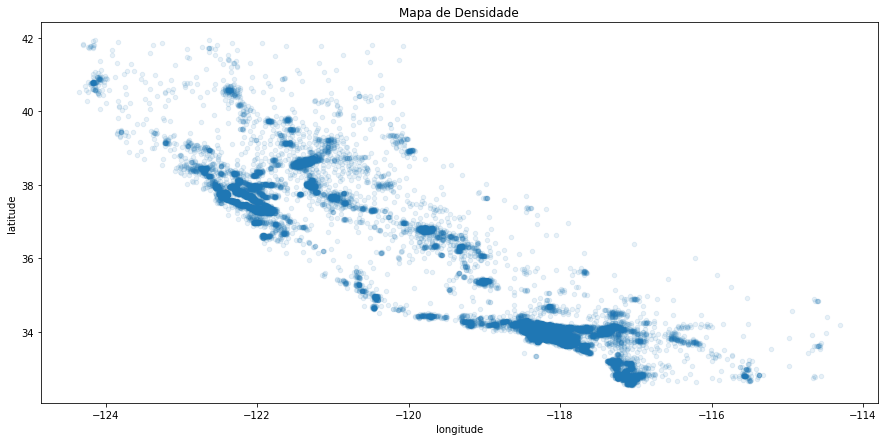

In [53]:
%matplotlib inline
housing_df.plot(kind="scatter", title="Mapa de Densidade", x="longitude", y="latitude", alpha=0.1, figsize=(15, 7))
plt.show()

Com a representação de densidade de habitações por localização geográfica nota-se uma maior concentração de habitações em zonas junto à costa marítima.

#### Análise do custo das habitações por densidade populacional numa zona geográfica

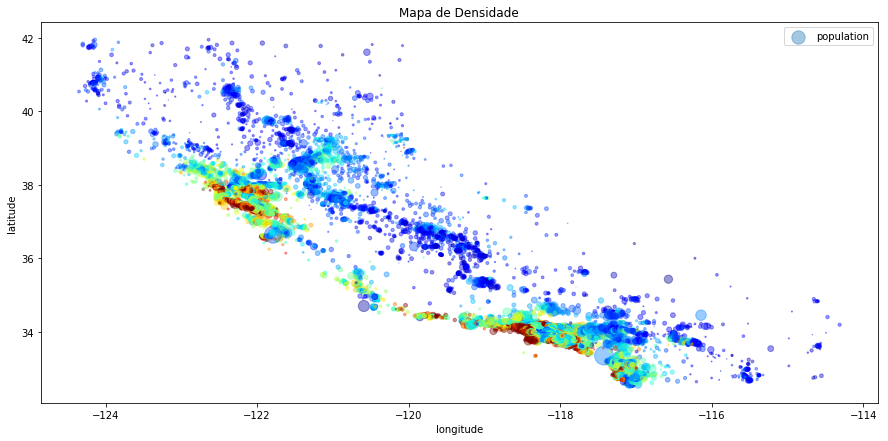

In [54]:
%matplotlib inline
housing_df.plot(kind="scatter", title="Mapa de Densidade", x="longitude", y="latitude", alpha=0.4, 
             s=housing_df["population"]/100, label="population", figsize=(15, 7), c="median_house_value",
             cmap=plt.get_cmap("jet"), colorbar=False)

plt.show()

Com esta representação, é possível analisar que o custo das habitações aumenta consoante a localização destas. Quanto mais próximo da costa marítima, mais caras são. É também possível notar que nestas zonas é onde existe maior concentração populacional.

#### Representação das habitações por localização geográfica e coloração de acordo com o preço. 

* Vermelho: Preço mais elevado
* Azul: Preço mais baixo

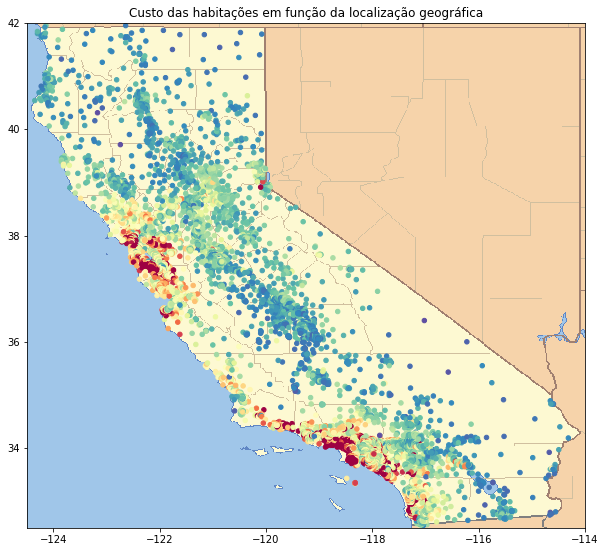

In [55]:
# %matplotlib notebook
%matplotlib inline

plt.scatter(housing_df['longitude'], housing_df['latitude'], 20, c=housing_df['median_house_value'], 
            cmap=cm.Spectral_r, zorder=1)

plt.gcf().set_size_inches((10,15))
bg_img = plt.imread('./dataset/cal_imgs/california.png')

ext = [-124.5, -114, 32.5, 42]
plt.imshow(bg_img, zorder=0, extent=ext)

plt.title("Custo das habitações em função da localização geográfica")

plt.show()

#### Análise das distribuições de cada feature

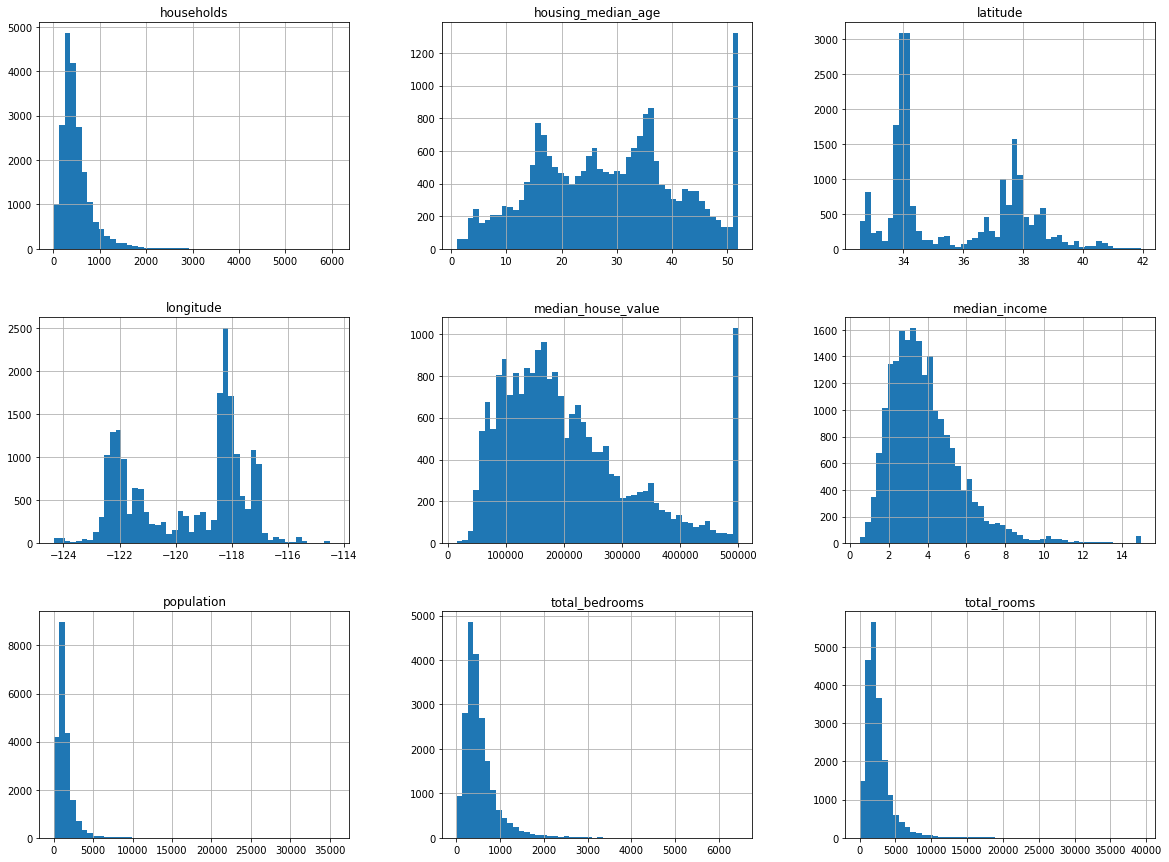

In [56]:
%matplotlib inline

housing_df.hist(bins=50, figsize=(20,15))
plt.show()

#### Análise da correlação entre features relativas às propriedades das habitações

In [57]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
housing_df[attributes].corr()

median_house_value  median_income  total_rooms  \
median_house_value            1.000000       0.688075     0.134153   
median_income                 0.688075       1.000000     0.198050   
total_rooms                   0.134153       0.198050     1.000000   
housing_median_age            0.105623      -0.119034    -0.361262   

                    housing_median_age  
median_house_value            0.105623  
median_income                -0.119034  
total_rooms                  -0.361262  
housing_median_age            1.000000

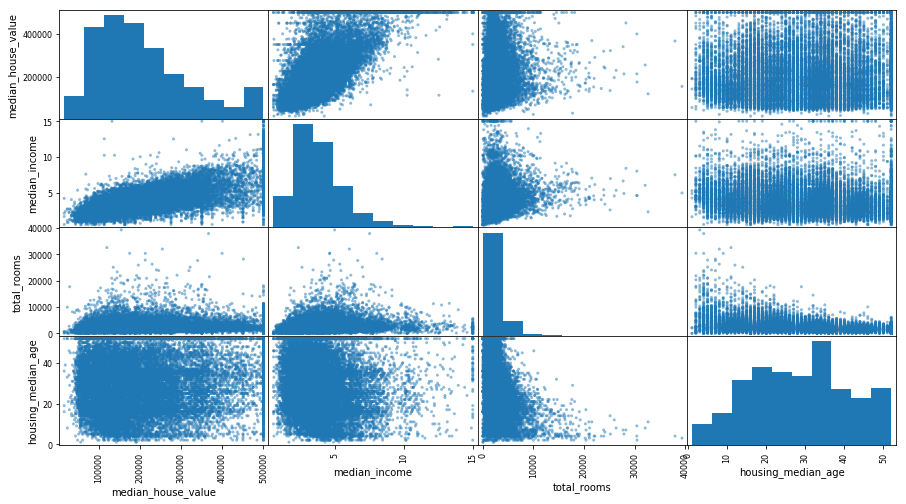

In [58]:
scatter_matrix(housing_df[attributes], figsize=(15, 8))
plt.show()

#### Análise da distribuição das labels

In [59]:
housing_df['median_house_value'] = housing_df['median_house_value'].apply(encode_price)

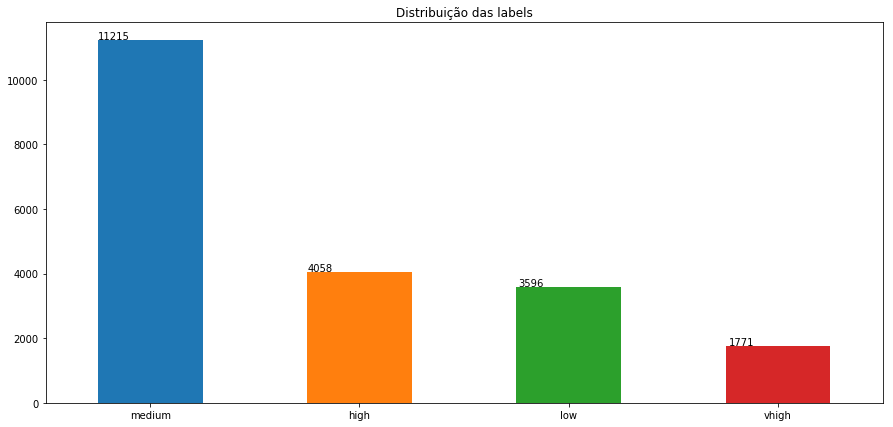

In [60]:
ax = pd.value_counts(housing_df['median_house_value']).plot(kind="bar", title="Distribuição das labels", 
                             rot=0, figsize=(15,7))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Através da análise da distribuição, é possível notar que cerca de 50% das habitações existentes neste dataset estão marcadas como tendo um preço médio.

## Preprocessamento

### Levantamento de valores nulos ou inválidos

In [61]:
housing_df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [62]:
X = housing_df[list(housing_df.columns[:-1])]
y = housing_df[list(housing_df.columns[-1:])]

## Feature Ranking

Tal como para o dataset anterior, foi realizado o mesmo teste estatístico (Teste F).

Este teste testa a hipótese de as variâncias das caraterísticas serem bastante diferentes, permitindo classificá-las de acordo com a influência que estas têm no resultado final.

<!--$$H_0: feature_{var} $$-->

Tendo um valor de alfa de 5%, tal como na utilização anterior, caso o valor-p seja inferior ao alfa, rejeita-se a hipótese nula, sendo assim a variância dessa caraterística elevada.


<!-- https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/f-statistic-value-test/#FandP -->

In [63]:
df_feature_ranking = pd.DataFrame()

alpha = 0.05

X_feature_rank = f_classif(X, y)

df_feature_ranking['feature'] = X.columns
df_feature_ranking['f_value'] = X_feature_rank[0]
df_feature_ranking['p_value'] = X_feature_rank[1]
df_feature_ranking['f_test'] = df_feature_ranking['p_value'].apply(lambda p: p < alpha)

#### Features menos relevantes | baixa variância

In [64]:
(df_feature_ranking[df_feature_ranking['f_test'] == False])

Empty DataFrame
Columns: [feature, f_value, p_value, f_test]
Index: []

#### Features mais relevantes | elevada variância

In [65]:
(df_feature_ranking[df_feature_ranking['f_test'] == True])

feature      f_value        p_value  f_test
0           longitude   106.355840   2.497236e-68    True
1            latitude   376.727056  3.064034e-238    True
2  housing_median_age   103.366109   2.040755e-66    True
3         total_rooms   163.524238  9.184812e-105    True
4      total_bedrooms    79.418820   4.461206e-51    True
5          population   108.384808   1.259025e-69    True
6          households   108.966234   5.349302e-70    True
7       median_income  4946.958529   0.000000e+00    True

Dado que este dataset tem apenas valores continuos, é percetível que a variância destes seja elevada, não sendo assim possível distinguir as features mais relevantes das menos relevantes através deste método estatístico.

Como o teste F não foi conclusivo, recorre-se à eliminação recursiva de features (RFE).

## RFE - Recursive Feature Elimination

Tal como para o dataset anterior, foi utilizado um método de eliminação de features para complementar o resultado obtido anteriormente.

Dado que este método utiliza um estimador para analisar de facto a importância relativa de cada feature, os resultados obtidos são mais conclusivos.

In [66]:
%%time
df_feature_ranking_rfe = pd.DataFrame()

selector = RFECV(LinearSVC(), step=1, cv=5)
selector = selector.fit(X, y)

CPU times: user 2min 51s, sys: 0 ns, total: 2min 51s
Wall time: 2min 51s


In [67]:
df_feature_ranking_rfe['feature'] = X.columns
df_feature_ranking_rfe['rank'] = selector.ranking_

df_feature_ranking_rfe.sort_values(by='rank')

feature  rank
7       median_income     1
1            latitude     2
0           longitude     3
2  housing_median_age     4
6          households     5
4      total_bedrooms     6
5          population     7
3         total_rooms     8

Com base na análise dos resultados do RFE é possível verificar que as features que apresentam maior influência no preço das habitações se referem principalmente ao salário mediano e distribuição geográfica das habitações.

Dado que as features não têm explicitamente relevâncias baixas, não foram descartadas nenhumas features.

## Normalização (Feature Scaling)

### Min-Max Normalization
Centrar os dados / Redução da amplitude dos dados

$X = \frac{X - min(X)}{max(X)-min(X)}$

In [68]:
minMaxScaler = MinMaxScaler()
X = minMaxScaler.fit_transform(X)

### Normalização Z-Score

Normalização Z-Score (Standard). Distribuição normal dos dados, em que $\mu=0$ e $\sigma=1$

$X = \frac{X-\mu}{\sigma}$

In [69]:
StdScaler = StandardScaler()
X = StdScaler.fit_transform(X)

## Análise da distribuição das features e correlações entre pares de features

In [70]:
pd.DataFrame(X).corr()

0         1         2         3         4         5         6  \
0  1.000000 -0.924664 -0.108197  0.044568  0.068378  0.099773  0.055310   
1 -0.924664  1.000000  0.011173 -0.036100 -0.066318 -0.108785 -0.071035   
2 -0.108197  0.011173  1.000000 -0.361262 -0.320485 -0.296244 -0.302916   
3  0.044568 -0.036100 -0.361262  1.000000  0.929893  0.857126  0.918484   
4  0.068378 -0.066318 -0.320485  0.929893  1.000000  0.878026  0.979829   
5  0.099773 -0.108785 -0.296244  0.857126  0.878026  1.000000  0.907222   
6  0.055310 -0.071035 -0.302916  0.918484  0.979829  0.907222  1.000000   
7 -0.015176 -0.079809 -0.119034  0.198050 -0.008093  0.004834  0.013033   

          7  
0 -0.015176  
1 -0.079809  
2 -0.119034  
3  0.198050  
4 -0.008093  
5  0.004834  
6  0.013033  
7  1.000000

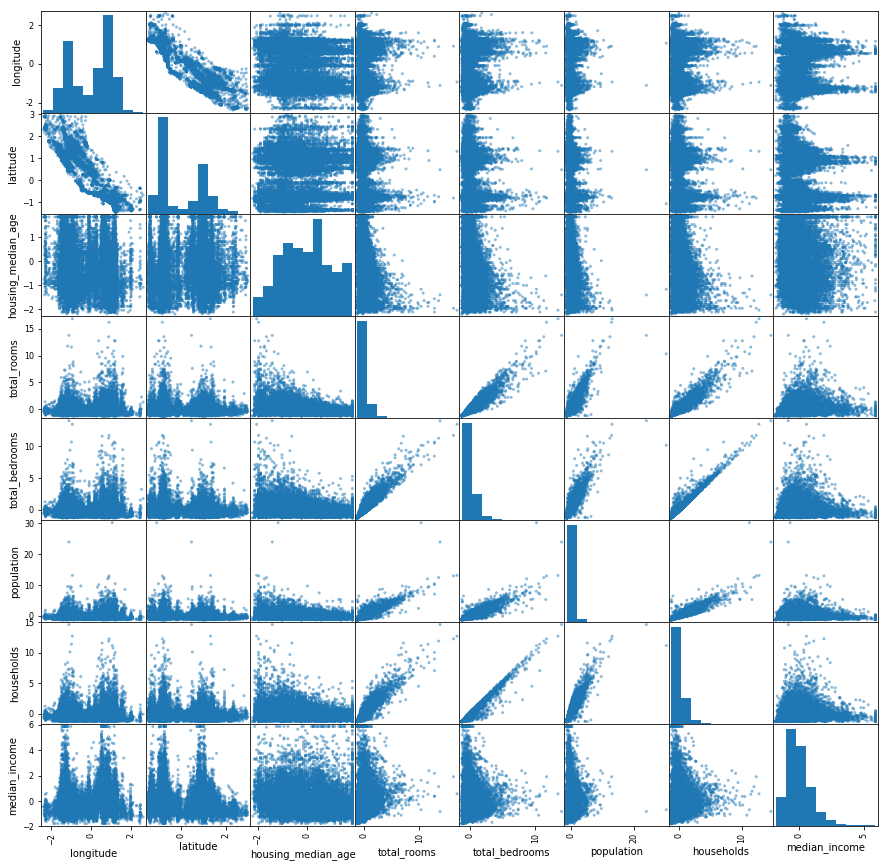

In [71]:
scatter_matrix(pd.DataFrame(X, columns=list(housing_df.columns[:-1])), figsize=(15, 15))
plt.show()

Através das figuras anteriores, é possível analisar correlações existentes entre as features.

Quanto maior a correlação melhor se nota um padrão de correlação entre estas, como por exemplo, as features **total_bedrooms** e **households** têm elevada correlação.

## Predictive Model

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVC - Support Vector Classifier

In [73]:
%%time
housing_svc = SVC()
housing_svc.fit(X_train, y_train)

CPU times: user 6.59 s, sys: 0 ns, total: 6.59 s
Wall time: 6.6 s


### Análise do desempenho - Holdout

In [74]:
print("Holdout Score: ")
model_evaluation_report(housing_svc.predict(X_test), y_test['median_house_value'])

Holdout Score: 
Confusion Matrix:
 [[ 414    0  131  149]
 [   2  485  109    1]
 [ 347  244 2024   49]
 [  25    1    3  144]]

Accuracy: 0.7429748062015504
Mean Precision: 0.6255998065224748
Mean Recall: 0.7502666996456386
Mean FScore: 0.6671862308918647
Ocurrences of each class: [ 694  597 2664  173]


### Análise do desempenho - Stratified K-Fold Cross-Validation

In [75]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(housing_svc, X, y, cv=skf)
scores

array([0.69273608, 0.67684109, 0.69331395, 0.61497456, 0.66973589])

In [76]:
print('Cross-Validation Scores Mean: ', scores.mean())

Cross-Validation Scores Mean:  0.6695203119325803


### GridSearch

In [77]:
%%time

params = {
    'kernel':['rbf'],
    'C':[x for x in range(10,100, 10)]
}

skf = StratifiedKFold(n_splits=5)

grid_search_svc = GridSearchCV(SVC(), params, cv=skf, verbose=True)
grid_search_svc.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  6.9min finished


CPU times: user 7min 4s, sys: 0 ns, total: 7min 4s
Wall time: 7min 4s


In [78]:
grid_search_svc.best_params_

{'C': 80, 'kernel': 'rbf'}

### Análise do desempenho - Cross-Validation

In [79]:
housing_svc = grid_search_svc.best_estimator_

gs_score = grid_search_svc.score(X_test, y_test)
print("Post-Parameter Tuning Prediction Accuracy: ", gs_score)

Post-Parameter Tuning Prediction Accuracy:  0.7652616279069767


## MLPClassifier - MultiLayer Perceptron Classifier

Dado que a utilização de PCA não se justifica com a utilização de SVMs, esse passo é apenas implementado após a utilização desse modelo para reduzir a dimensão dos dados, visto que o método de seleção das features mais relevantes através do teste F estatístico não revelou features cuja relevância fosse inferior. 

Dada a dimensão do dataset e após análise experimental do consumo de memória do KernelPCA, não foi possível testar este método, pois cada vez que foi testado, excedia a memória da máquina, terminando o kernel de IPython do notebook.

In [80]:
# %%time
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(kernel='poly', n_components=3)
# X_kpca = kpca.fit_transform(X)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_kpca[y['median_house_value']=='vhigh', 0], X_kpca[y['median_house_value']=='vhigh', 1], X_kpca[y['median_house_value']=='vhigh', 2], marker="+", color="#d6404e")
# ax.scatter(X_kpca[y['median_house_value']=='high', 0], X_kpca[y['median_house_value']=='high', 1], X_kpca[y['median_house_value']=='high', 2], marker="^", color="#fee18d")
# ax.scatter(X_kpca[y['median_house_value']=='medium', 0], X_kpca[y['median_house_value']=='medium', 1], X_kpca[y['median_house_value']=='medium', 2], marker="D", color="#acdda3")
# ax.scatter(X_kpca[y['median_house_value']=='low', 0], X_kpca[y['median_house_value']=='low', 1], X_kpca[y['median_house_value']=='low', 2], marker="_", color="#3e77b5")
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')

# plt.show()

#### Representação dos dados em apenas duas dimensões

In [81]:
from sklearn.decomposition import PCA
from math import sqrt
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

print("Covariância:\n", pca.get_covariance())
print("Valores singulares:\n", pca.singular_values_)
print("Valores próprios:\n", pca.explained_variance_ratio_)
print("Direções principais:\n", pca.components_)
mean_vector = pca.mean_
print("Vetor médio:\n", mean_vector)

Covariância:
 [[ 1.07519959 -0.85058106 -0.06117294  0.04222785  0.07048264  0.10626077
   0.06714004  0.01209595]
 [-0.85058106  1.07296181  0.07354907 -0.04088617 -0.0613742  -0.09740666
  -0.05829985 -0.04442209]
 [-0.06117294  0.07354907  0.53076941 -0.41853209 -0.35401699 -0.34033898
  -0.35750266 -0.33532141]
 [ 0.04222785 -0.04088617 -0.41853209  1.10164837  0.87259836  0.83527811
   0.87573073  0.1464075 ]
 [ 0.07048264 -0.0613742  -0.35401699  0.87259836  1.12694405  0.86712157
   0.90597079 -0.01068214]
 [ 0.10626077 -0.09740666 -0.34033898  0.83527811  0.86712157  1.05597722
   0.86859972 -0.01101338]
 [ 0.06714004 -0.05829985 -0.35750266  0.87573073  0.90597079  0.86859972
   1.13045199 -0.00480745]
 [ 0.01209595 -0.04442209 -0.33532141  0.1464075  -0.01068214 -0.01101338
  -0.00480745  0.90643519]]
Valores singulares:
 [283.96112639 198.44403284 148.7457042 ]
Valores próprios:
 [0.48833528 0.23849342 0.13399518]
Direções principais:
 [[ 0.07564067 -0.07302205 -0.21849897  

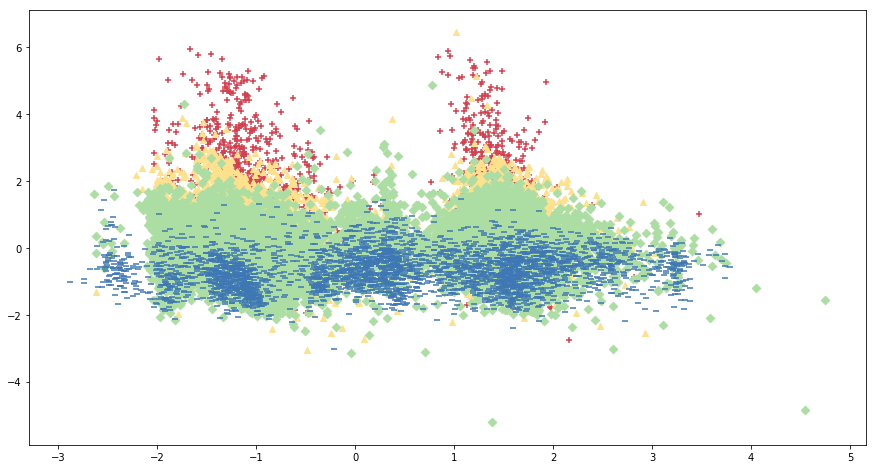

In [82]:
plt.figure(figsize=(15, 8))
plt.scatter(X_pca[y['median_house_value']=='vhigh', 1], X_pca[y['median_house_value']=='vhigh', 2], marker="+", color="#d6404e")
plt.scatter(X_pca[y['median_house_value']=='high', 1], X_pca[y['median_house_value']=='high', 2], marker="^", color="#fee18d")
plt.scatter(X_pca[y['median_house_value']=='medium', 1], X_pca[y['median_house_value']=='medium', 2], marker="D", color="#acdda3")
plt.scatter(X_pca[y['median_house_value']=='low', 1], X_pca[y['median_house_value']=='low', 2], marker="_", color="#3e77b5")

In [83]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[y['median_house_value']=='vhigh', 0], X_pca[y['median_house_value']=='vhigh', 1], X_pca[y['median_house_value']=='vhigh', 2], marker="+", color="#d6404e")
# ax.scatter(X_pca[y['median_house_value']=='high', 0], X_pca[y['median_house_value']=='high', 1], X_pca[y['median_house_value']=='high', 2], marker="^", color="#fee18d")
# ax.scatter(X_pca[y['median_house_value']=='medium', 0], X_pca[y['median_house_value']=='medium', 1], X_pca[y['median_house_value']=='medium', 2], marker="D", color="#acdda3")
# ax.scatter(X_pca[y['median_house_value']=='low', 0], X_pca[y['median_house_value']=='low', 1], X_pca[y['median_house_value']=='low', 2], marker="_", color="#3e77b5")
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')

# plt.show()

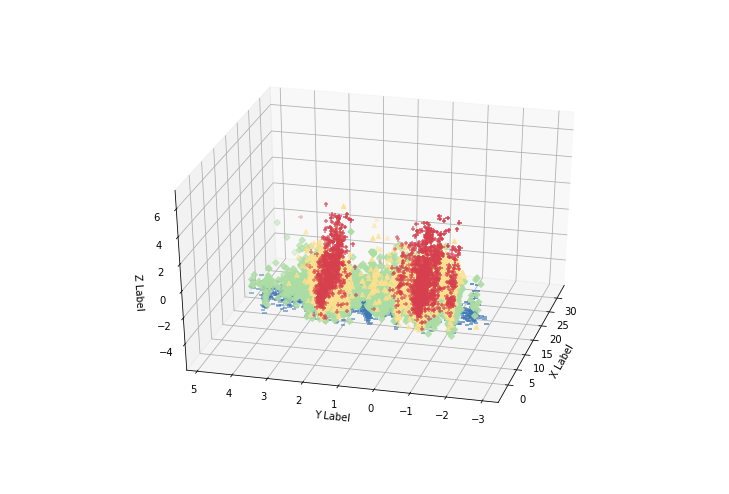

In [84]:
Image(filename = '3dplot.png')

In [85]:
%%time
mlp = MLPClassifier(hidden_layer_sizes=(15, 10), activation="tanh", 
                    solver='sgd', verbose=0, tol=1e-4,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)

CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.55 s


### Análise de desempenho - Holdout

In [86]:
print("Holdout score: ")
model_evaluation_report(mlp.predict(X_test), y_test['median_house_value'])

Holdout score: 
Confusion Matrix:
 [[ 496    1  183  138]
 [   1  509  116    1]
 [ 248  219 1962   33]
 [  43    1    6  171]]

Accuracy: 0.7601744186046512
Mean Precision: 0.6726762835034634
Mean Recall: 0.7472069839940865
Mean FScore: 0.7010061578346322
Ocurrences of each class: [ 818  627 2462  221]


### Análise de desempenho - Cross-Validation

In [87]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(mlp, X, y, cv=skf)
scores

array([0.70435835, 0.71172481, 0.66254845, 0.63968985, 0.71262418])

In [88]:
print('Cross-Validation Scores Mean: ', scores.mean())

Cross-Validation Scores Mean:  0.6861891277772548


#### Ilustração da representação do MLP

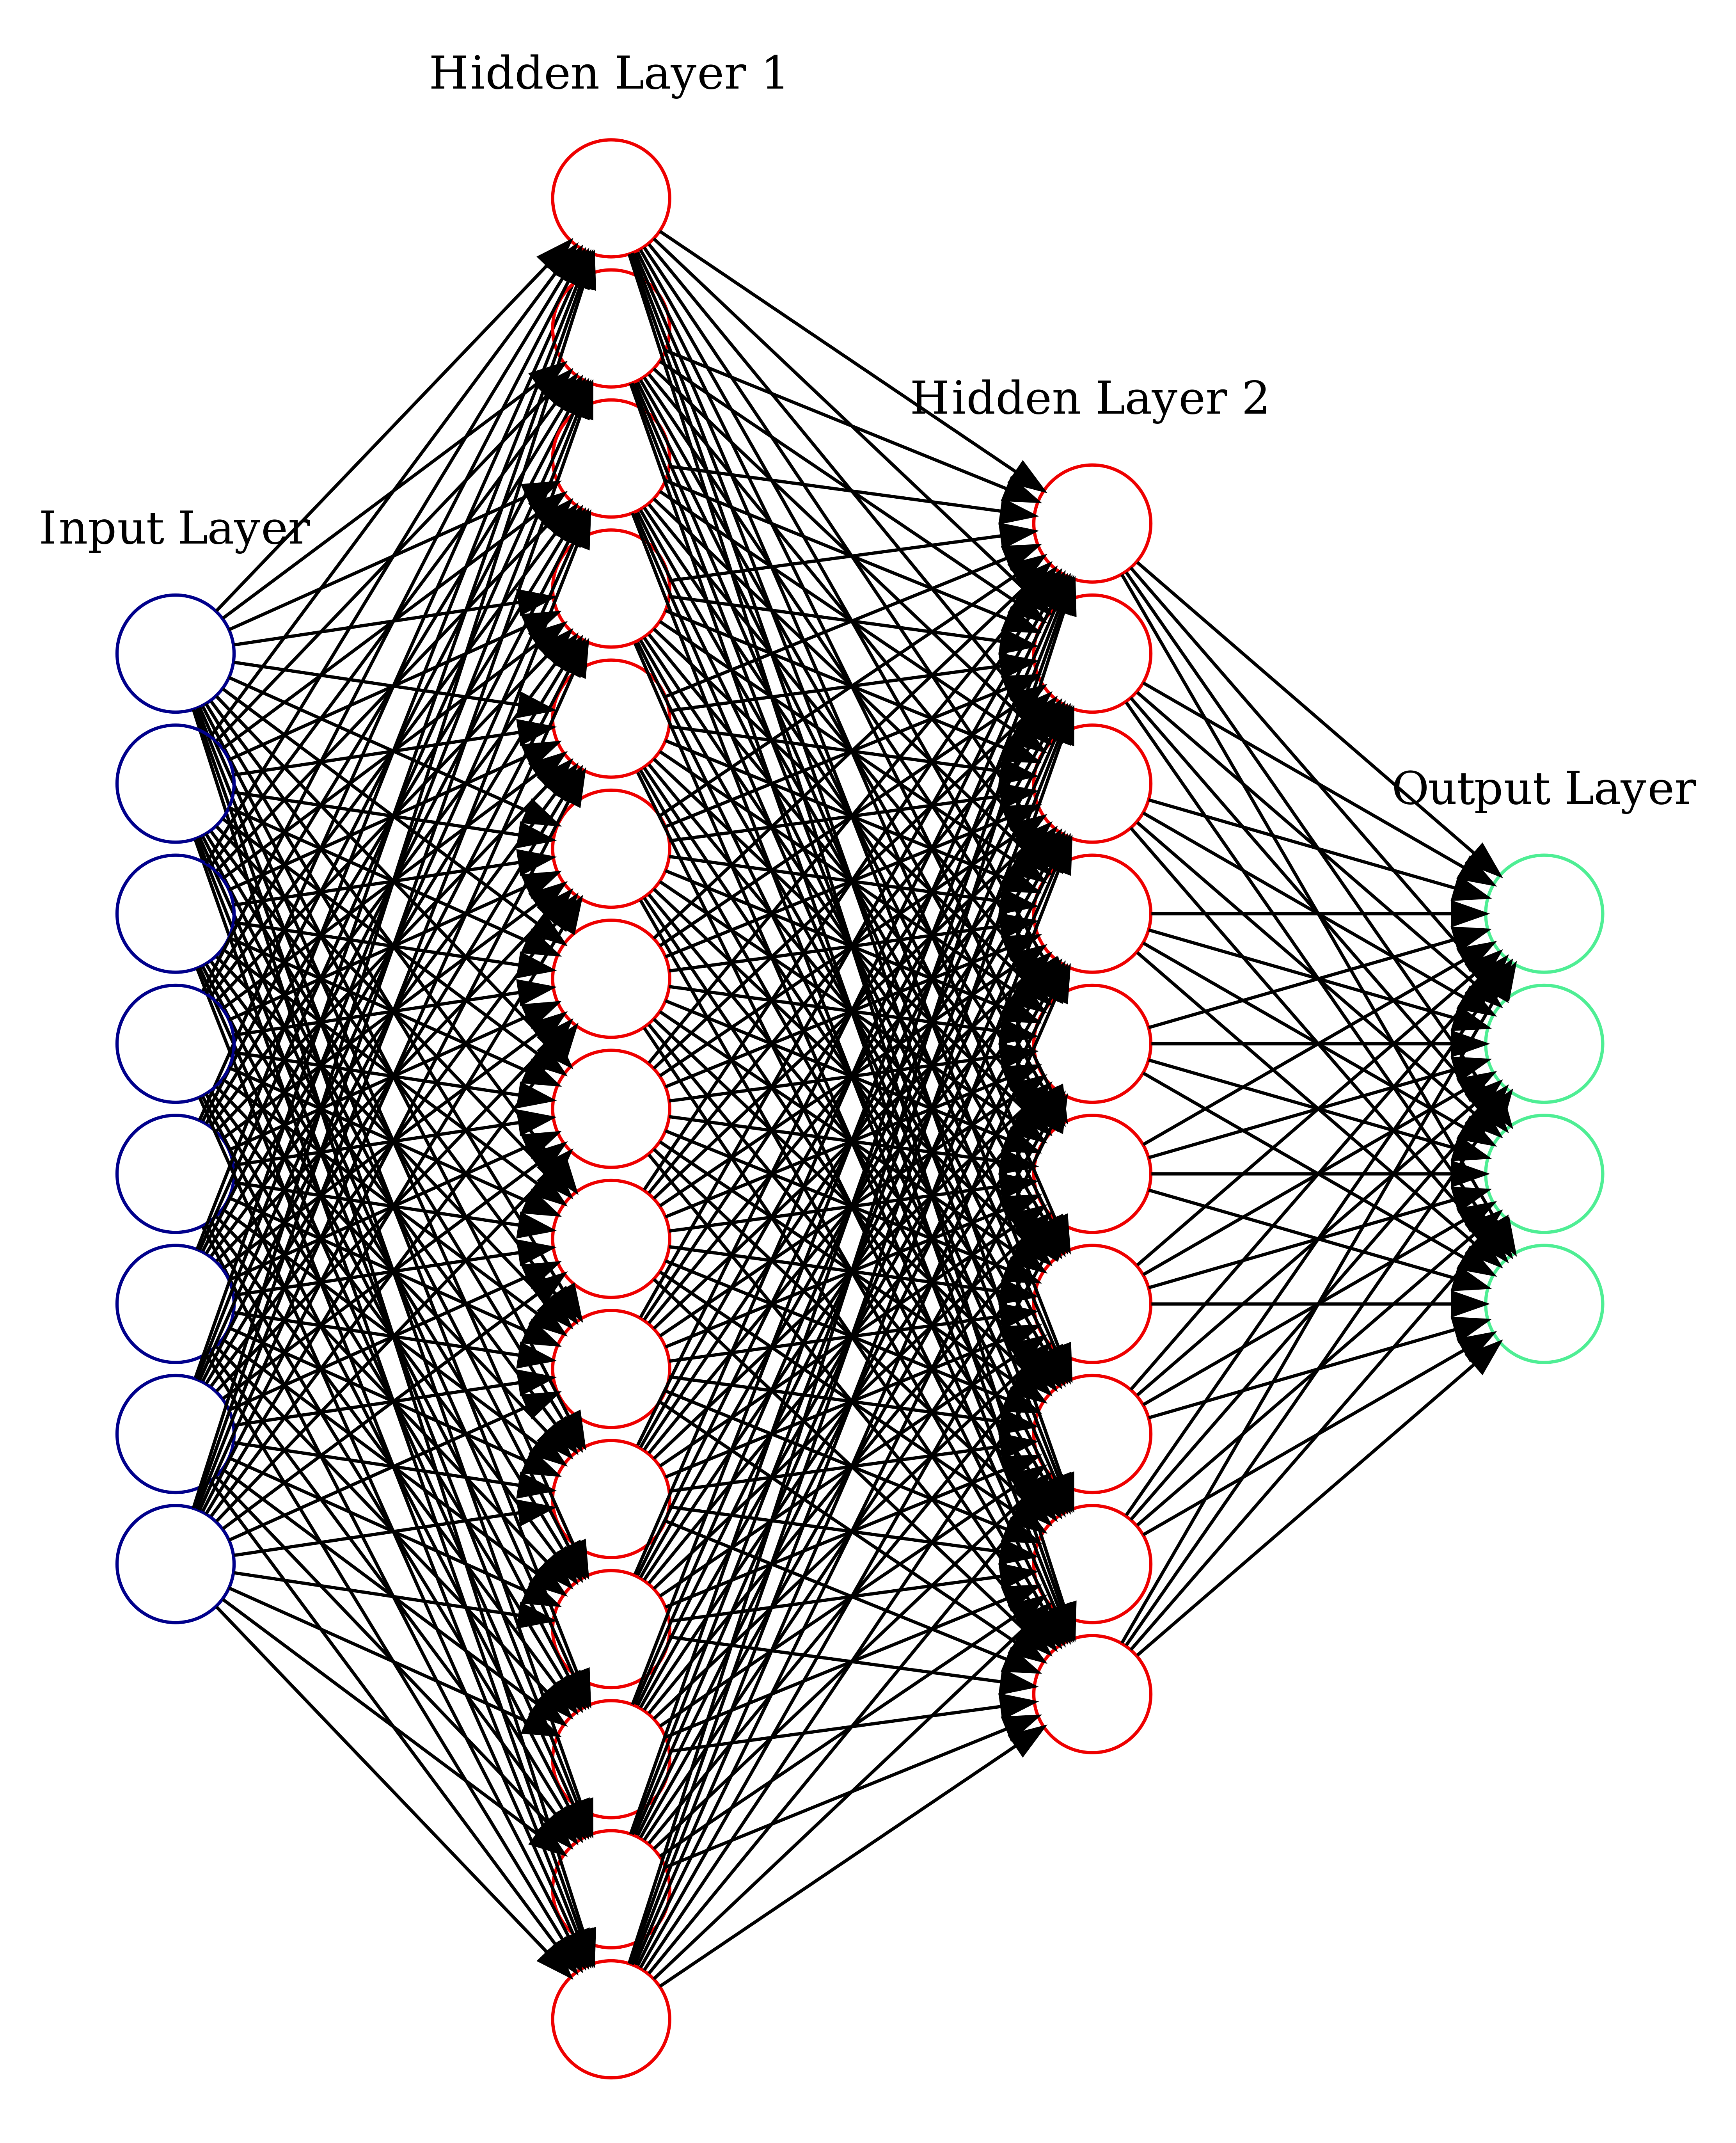

In [89]:
Image(filename = 'mlp_scheme.png', width=600)

## Conclusão

Analisando os classificadores utilizados para este dataset e para o problema específico a que este dataset se destina, é de notar que os resultados são relativamente mais baixos comparativamente aos classificadores utilizados no dataset "Car Evaluation", isto tanto porque este dataset é mais complexo, tem uma quantidade superior de valores numéricos contínuos e este dataset é principalmente utilizado em problemas de regressão.

A escolha deste dataset foi baseada na sua complexidade e no interesse que poderia representar para a fase de análise e visualização dos dados, dado que esta é das principais fases num projeto da área de Data Mining.

Dada a dimensão deste dataset, optou-se por não utilizar a avaliação por nested cross-validation, devido ao tempo de execução que este leva. Foi apenas utilizado o holdout e cross-validation para efeitos de comparação entre métodos de avaliação e para ser possível a comparação de modelos.